Loop 1: Elastic Area = 82.10, Total Area = 166.00
Elastic Ratio = 49.46% → Ductile
Estimated E: 1.12 GPa --> Outside PLA range (2–4 GPa)


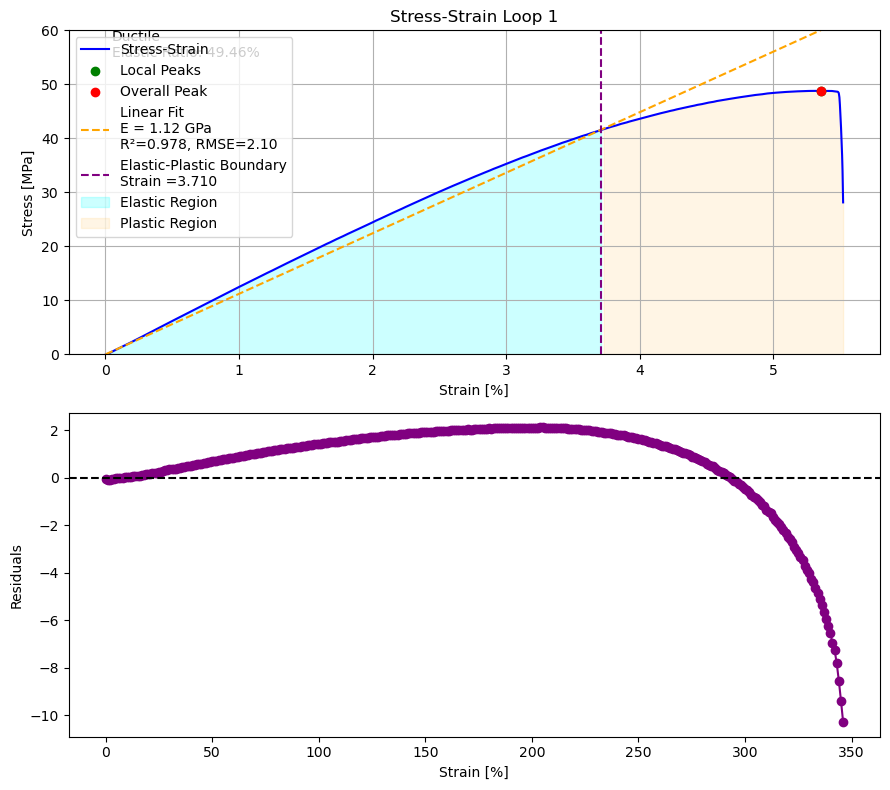

Loop 2: Elastic Area = 86.91, Total Area = 993.88
Elastic Ratio = 8.74% → Ductile
Estimated E: 1.19 GPa --> Outside PLA range (2–4 GPa)


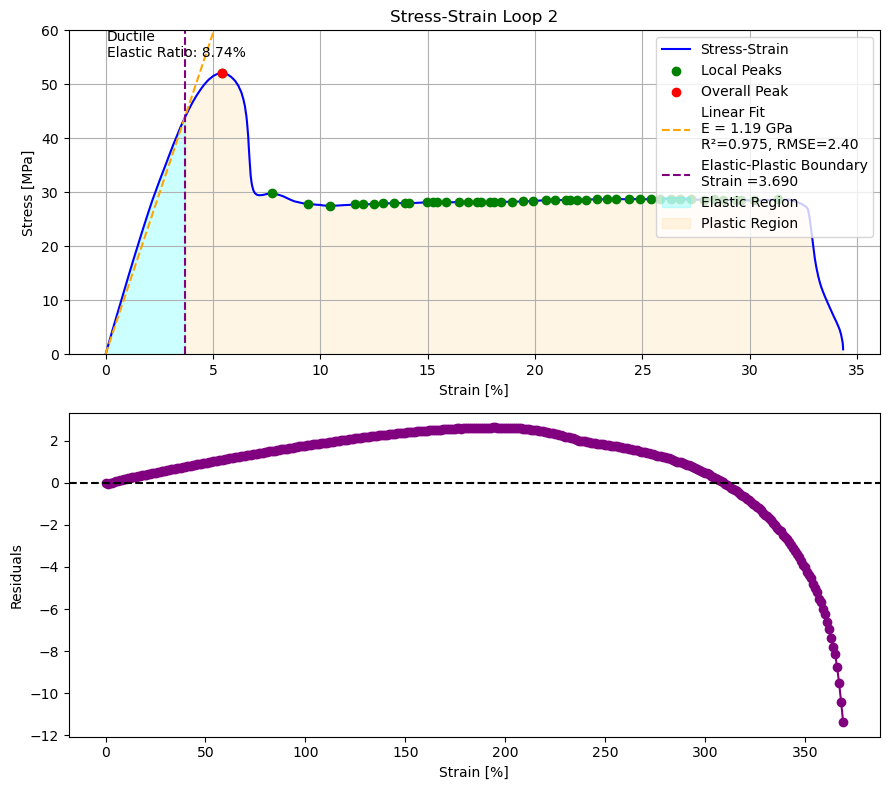

Loop 3: Elastic Area = 84.01, Total Area = 149.25
Elastic Ratio = 56.29% → Brittle (Elastic-Dominated)
Estimated E: 1.15 GPa --> Outside PLA range (2–4 GPa)


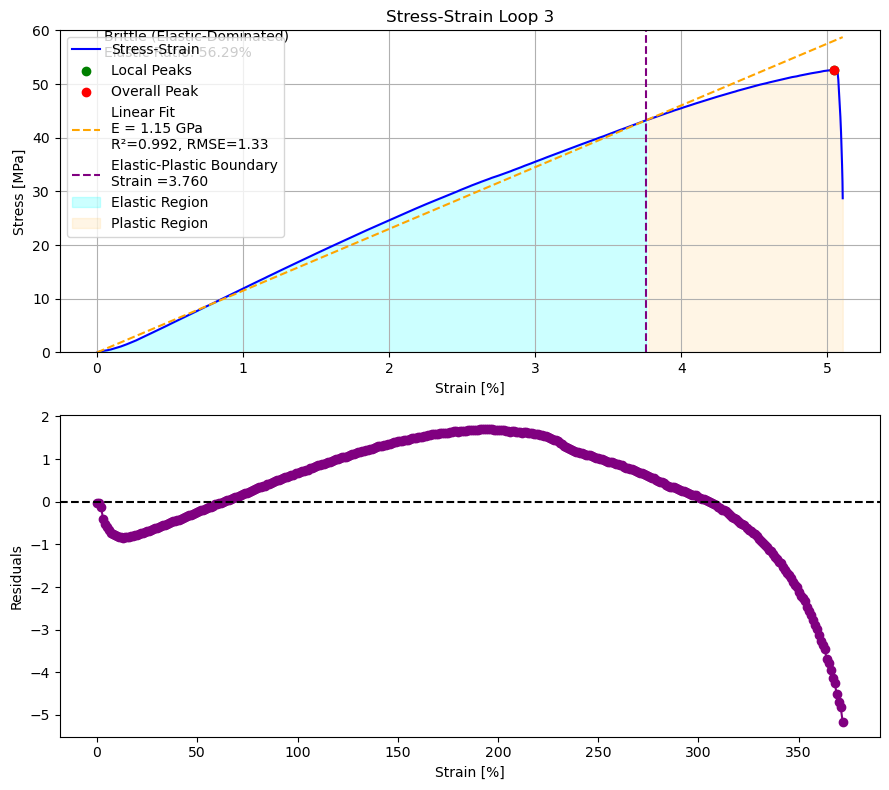

Loop 4: Elastic Area = 68.43, Total Area = 123.35
Elastic Ratio = 55.48% → Brittle (Elastic-Dominated)
Estimated E: 1.20 GPa --> Outside PLA range (2–4 GPa)


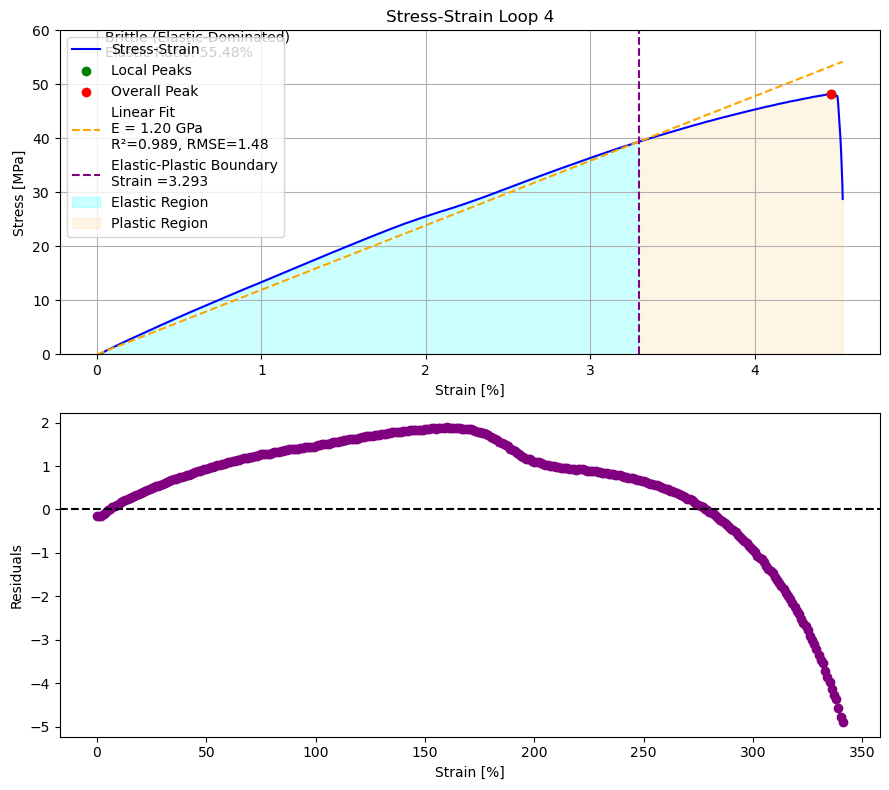

Loop 5: Elastic Area = 77.37, Total Area = 146.72
Elastic Ratio = 52.74% → Brittle (Elastic-Dominated)
Estimated E: 1.21 GPa --> Outside PLA range (2–4 GPa)


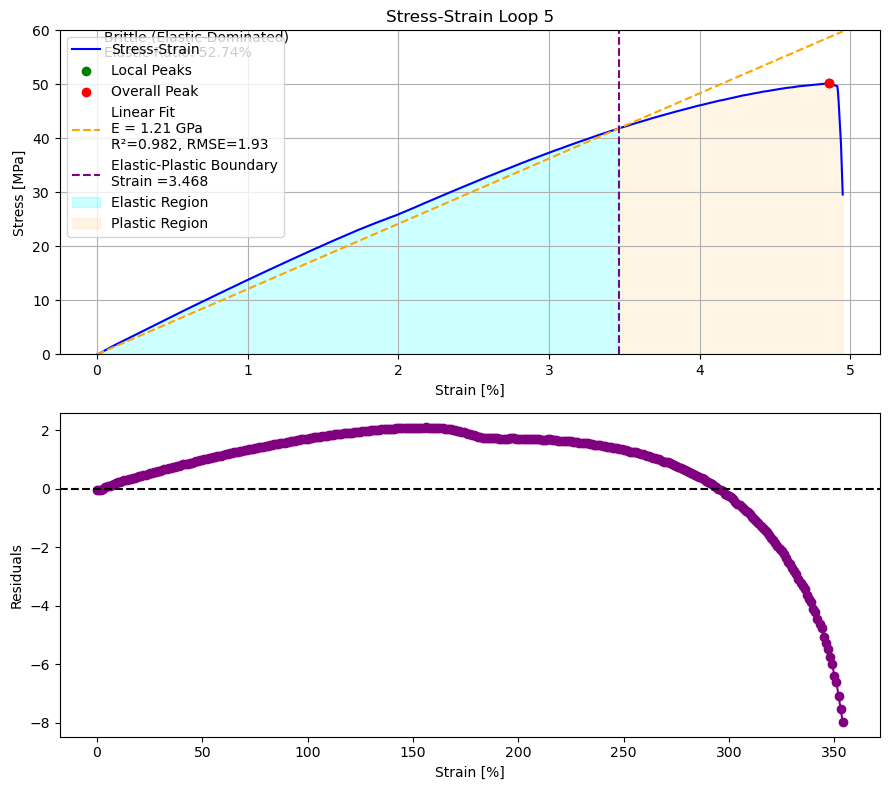

Loop 6: Elastic Area = 80.48, Total Area = 258.68
Elastic Ratio = 31.11% → Ductile
Estimated E: 1.17 GPa --> Outside PLA range (2–4 GPa)


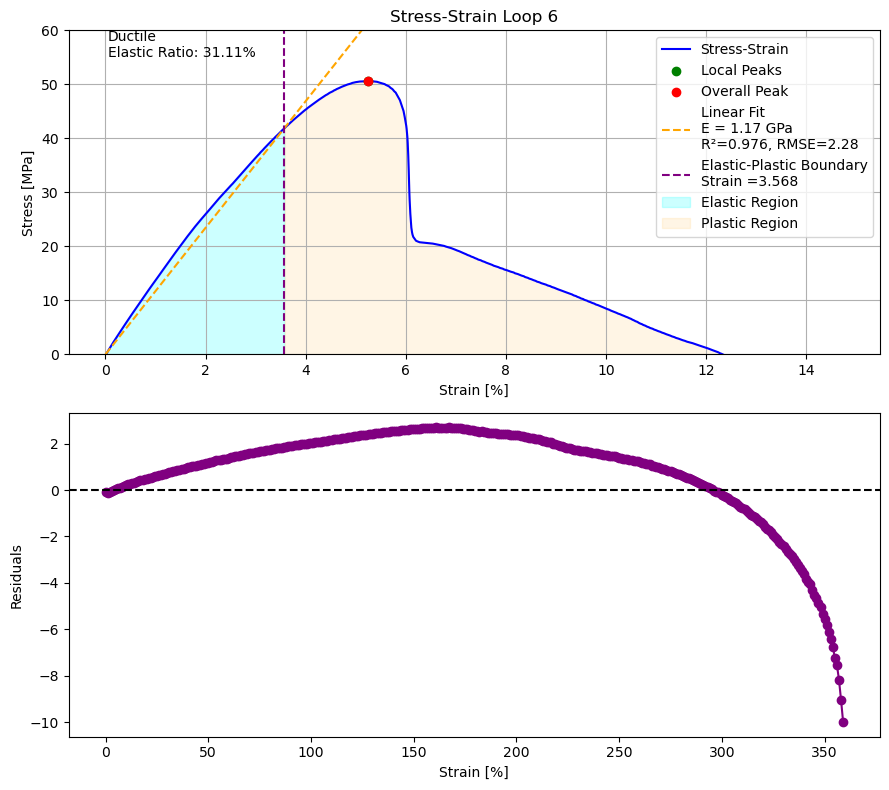

Loop 7: Elastic Area = 82.06, Total Area = 304.06
Elastic Ratio = 26.99% → Ductile
Estimated E: 1.16 GPa --> Outside PLA range (2–4 GPa)


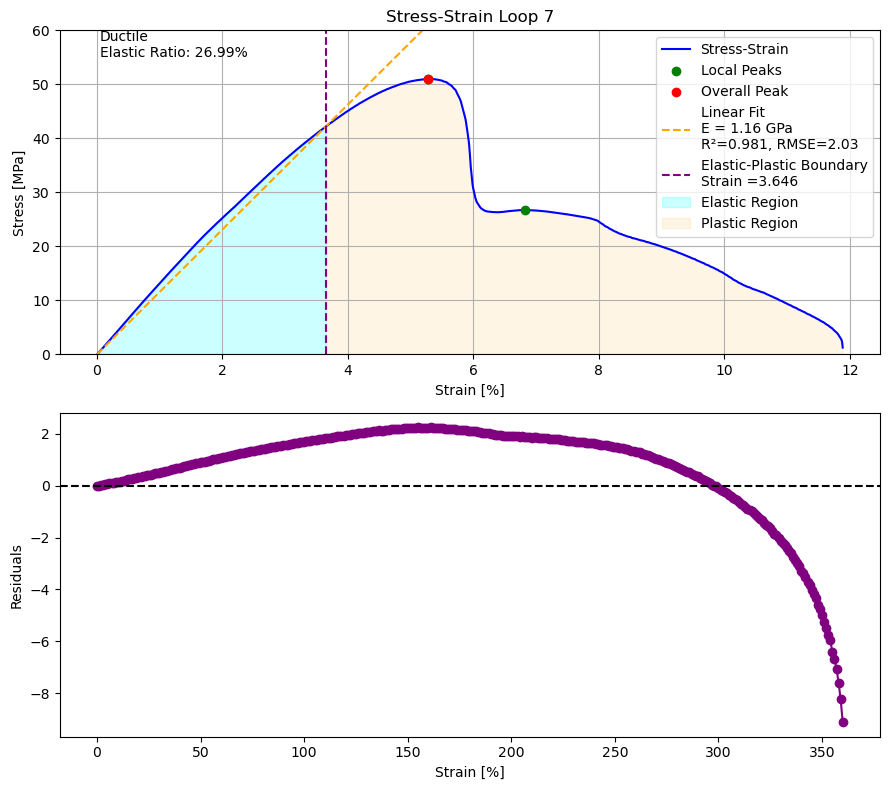

Loop 8: Elastic Area = 61.96, Total Area = 115.97
Elastic Ratio = 53.43% → Brittle (Elastic-Dominated)
Estimated E: 1.17 GPa --> Outside PLA range (2–4 GPa)


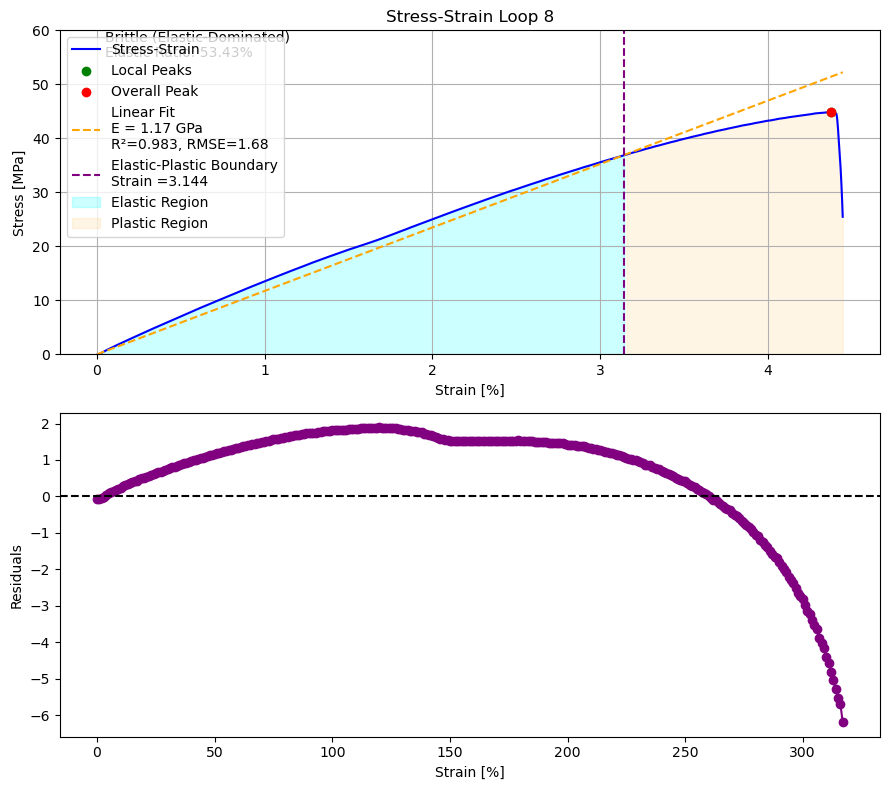

Loop 9: Elastic Area = 71.28, Total Area = 332.05
Elastic Ratio = 21.47% → Ductile
Estimated E: 1.16 GPa --> Outside PLA range (2–4 GPa)


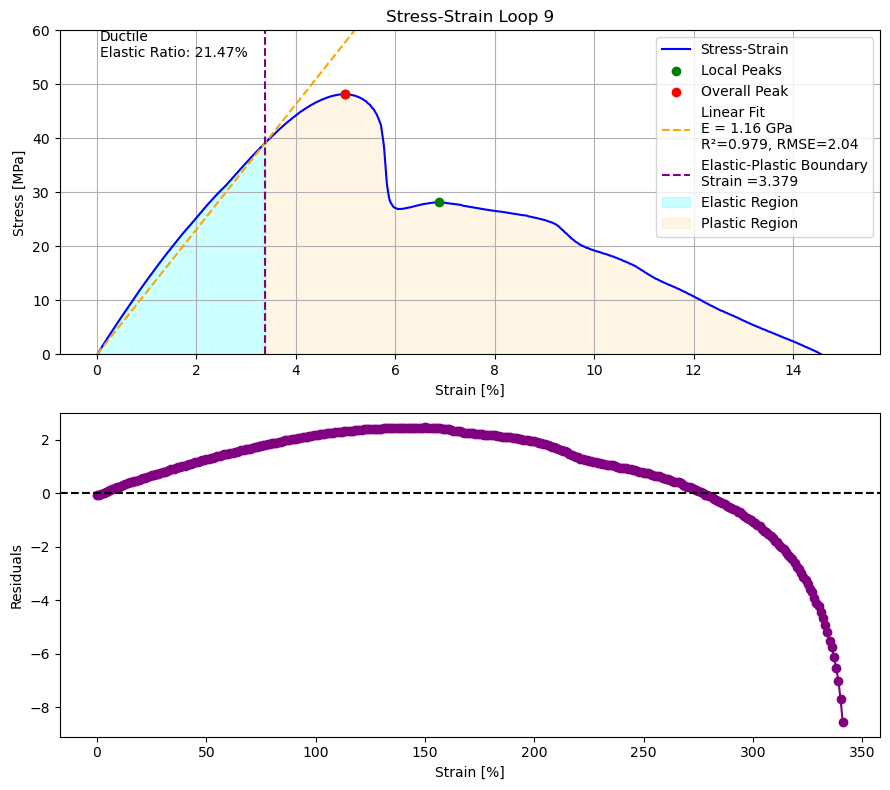

In [28]:
#Data processing from a Universal Testing Machines' raw data
#Includes raw data plot, loop separation, peak finding, linear regression to indentify Young's modulus, area calculation to indentify brittleness
#In presentation, someone asked why linear regression didn't go through initial point(0,0).
#The LinearRegression model from sklearn includes an intercept term by default.This means the regression line is of the form:y=mx+b,where b (the intercept) is not forced to be 0.
#In this updated model, I forced the linear regression not to fit an intercept to better decribe this situation
#Also, the Professor suggested to validate the Young's modulus. In this updated code, I compare the calculated result with PLA's standard Young's modulus.
#Please also download the file "pla.raw" for testing.
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Open file
file_path = "pla.raw"
with open(file_path, 'r') as f:
    lines = f.readlines()

# Extract header and data
header_line = lines[30].strip().replace('"', '')
columns = header_line.split(',')
data_lines = [line.strip().split(',') for line in lines[31:]]
df = pd.DataFrame(data_lines, columns=columns)

df["Strain [Exten.] %"] = pd.to_numeric(df["Strain [Exten.] %"], errors='coerce')
df["Stress MPa"] = pd.to_numeric(df["Stress MPa"], errors='coerce')
df = df.dropna(subset=["Strain [Exten.] %", "Stress MPa"]).reset_index(drop=True)

# Find strain resets to define loops
strain = df["Strain [Exten.] %"]
reset_indices = [0]
for i in range(1, len(strain)):
    if strain[i] < 0.01 and strain[i - 1] > 0.05:
        reset_indices.append(i)
reset_indices.append(len(df))

for i in range(len(reset_indices) - 1):
    start = reset_indices[i]
    end = reset_indices[i + 1]
    segment = df.iloc[start:end].copy()

# Find local peaks
    peaks, _ = find_peaks(segment["Stress MPa"])
    peak_strains = segment.iloc[peaks]["Strain [Exten.] %"].values
    peak_stresses = segment.iloc[peaks]["Stress MPa"].values

# Find overall peak
    max_idx = segment["Stress MPa"].idxmax()
    max_strain = df.loc[max_idx, "Strain [Exten.] %"]
    max_stress = df.loc[max_idx, "Stress MPa"]

# Linear regression on data before first local peak
    if len(peaks) > 0:
        first_peak_index = peaks[0]
        segment_pre_peak = segment.iloc[:first_peak_index]
    else:
        segment_pre_peak = segment

    X = segment_pre_peak["Strain [Exten.] %"].values.reshape(-1, 1)
    y = segment_pre_peak["Stress MPa"].values

    if len(X) >= 2:
# Linear regression forced through origin point (0,0)
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        y_pred = model.predict(X)

        slope = model.coef_[0]
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        residuals = y - y_pred

        full_X = segment["Strain [Exten.] %"].values
        full_y = segment["Stress MPa"].values
        lin_fit_full = model.predict(full_X.reshape(-1, 1))

# Yield point estimation
        diff = full_y - lin_fit_full
        sign_change_indices = np.where(np.diff(np.sign(diff)))[0]

        if len(sign_change_indices) > 0:
            last_cross_idx = sign_change_indices[-1] + 1
            yield_strain = full_X[last_cross_idx]
            yield_stress = full_y[last_cross_idx]
        else:
            yield_strain = full_X[-1]
            yield_stress = full_y[-1]

# Area Calculations
        total_area = np.trapz(full_y, full_X)
        elastic_mask = full_X <= yield_strain
        strain_elastic = full_X[elastic_mask]
        stress_elastic = full_y[elastic_mask]
        elastic_area = np.trapz(stress_elastic, strain_elastic)
        elastic_ratio = elastic_area / total_area if total_area > 0 else 0
        behavior = "Ductile" if elastic_ratio < 0.5 else "Brittle (Elastic-Dominated)"

# Validate Young's Modulus
        E_GPa = slope * 100 / 1000
        within_range = 2.0 <= E_GPa <= 4.0
        print(f"Loop {i + 1}: Elastic Area = {elastic_area:.2f}, Total Area = {total_area:.2f}")
        print(f"Elastic Ratio = {elastic_ratio:.2%} → {behavior}")
        print(f"Estimated E: {E_GPa:.2f} GPa --> {'Within' if within_range else 'Outside'} PLA range (2–4 GPa)")


# Plotting
    fig, axs = plt.subplots(2, 1, figsize=(9, 8))
    ax_main, ax_res = axs

    ax_main.plot(segment["Strain [Exten.] %"], segment["Stress MPa"], color='blue', label="Stress-Strain")
    ax_main.scatter(peak_strains, peak_stresses, color='green', label="Local Peaks", zorder=5)
    ax_main.scatter(max_strain, max_stress, color='red', label="Overall Peak", zorder=6)
    
    if slope is not None:
        ax_main.plot(full_X, lin_fit_full, color='orange', linestyle='--',
                     label=f"Linear Fit\nE = {E_GPa:.2f} GPa\nR²={r2:.3f}, RMSE={rmse:.2f}")
        ax_main.axvline(x=yield_strain, color='purple', linestyle='--',
                        label=f"Elastic-Plastic Boundary\nStrain ={yield_strain:.3f}")
        ax_main.fill_between(full_X, full_y, where=full_X <= yield_strain,
                             color='cyan', alpha=0.2, label="Elastic Region")
        ax_main.fill_between(full_X, full_y, where=full_X > yield_strain,
                             color='orange', alpha=0.1, label="Plastic Region")

        ax_res.plot(residuals, marker='o', color='purple')
        ax_res.axhline(0, color='black', linestyle='--')
        ax_res.set_ylabel("Residuals")
        ax_res.set_xlabel("Strain [%]")
    else:
        ax_res.set_visible(False)

    ax_main.set_xlabel("Strain [%]")
    ax_main.set_ylabel("Stress [MPa]")
    ax_main.set_ylim(0, 60)
    ax_main.set_title(f"Stress-Strain Loop {i + 1}")
    ax_main.text(0.05, 55, f"{behavior}\nElastic Ratio: {elastic_ratio:.2%}",
                 fontsize=10, color='black')
    ax_main.legend()
    ax_main.grid(True)
    plt.tight_layout()
    plt.show()
